# Clustering

In this guide, you'll learn how to use `sklearn-evaluation`, and `sklearn` to evaluate clustering models.

```{note}
This guide requires `scikit-learn>=1.2`
```

## Sample clustering model

Let's generate some sample data with 5 clusters; note that in most real-world use cases, you won't have ground truth data labels (which cluster a given observation belongs to). However, in this case, the ground truth data is available, which will help us explain the concepts more clearly.

In [1]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=20,
    random_state=0,
    cluster_std=3,
    center_box=(-10, 10),
)

## Visualizing clusters

Visualizing high-dimensional data is difficult. A common approach is to reduce its dimensionality using PCA; this losses some information but can help us visualize the clusters. Let's run PCA on our data and plot it:

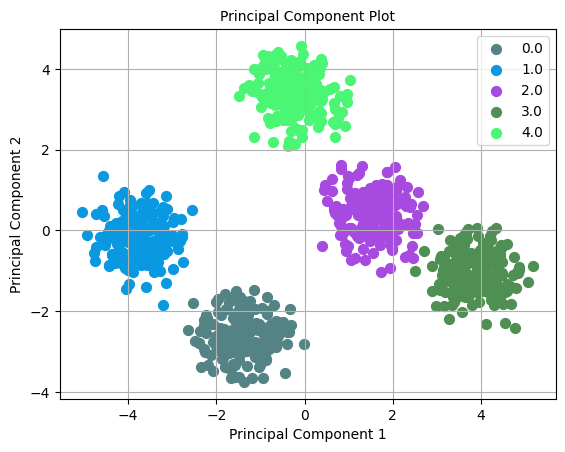

In [2]:
from sklearn_evaluation import plot

_ = plot.pca(X, y, n_components=2)

We can see the clusters in our synthetic data. However, the clusters won't be as transparent when using real-world datasets as in our example dataset.

## Evaluation metrics

When clustering data, we want to find the number of clusters that better fit the data. Most models have `n_clusters` as a parameter, so we have to try different values and evaluate which number is the best. To find the *best model*, we need to quantify the quality of the clusters. Here are three metrics you can use that do not require ground truth data:

- `silhouette_score`: goes from -1 to +1, **higher is better** defined clusters ([documentation](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient))
- `calinski_harabasz_score`: a ratio, **higher is better** ([documentation](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index))
- `davies_bouldin_score`: **lower is better**, minimum value is 0 ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html#sklearn.metrics.davies_bouldin_score))

Let's run a `KMeans` algorithm with different `n_clusters` and compute all three metrics; we'll highlight the metric value that best fits the data:

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics


def score(X, n_clusters):
    model = KMeans(n_init="auto", n_clusters=n_clusters, random_state=1)
    model.fit(X)
    predicted = model.predict(X)
    return {
        "n_clusters": n_clusters,
        "silhouette_score": metrics.silhouette_score(X, predicted),
        "calinski_harabasz_score": metrics.calinski_harabasz_score(X, predicted),
        "davies_bouldin_score": metrics.davies_bouldin_score(X, predicted),
    }


df_metrics = pd.DataFrame(
    score(X, n_clusters) for n_clusters in (2, 3, 4, 5, 6, 7, 8, 9, 10)
)
df_metrics.set_index("n_clusters", inplace=True)

(
    df_metrics.style.highlight_max(
        subset=["silhouette_score", "calinski_harabasz_score"], color="lightgreen"
    ).highlight_min(subset=["davies_bouldin_score"], color="lightgreen")
)

All three metrics have their *best* value when `n_clusters=5`. We know this is the best value since our data has 5 clusters; however, when using real datasets, you might find that these metrics might not agree, so it's advisable to understand how each metric is computed and choose the best one for your project.

You can also find the best number of clusters visually. Let's see how to do it using an elbow curve.

## Optimal number of clusters

### `plot.elbow_curve`

```{important}
Currently, `plot.elbow_curve` only works with the following sklearn models: `KMeans`, `BisectingKMeans`, and `MiniBatchKMeans`
```

An elbow curve evaluates the sum of squared errors (i.e., how far each point is from its assigned cluster center). So, naturally, the more centers you have, the lower this metric will be. However, a good clustering model does not necessarily minimize this metric but balances the trade-off between lowering the sum of squared errors and having a small number of clusters (since those two are competing objectives).

The elbow curve will plot the sum of squared errors for a different number of clusters; then, you can visually evaluate when increasing the number of clusters is not worth it, as it'll not yield a significant decrease in the sum of squared errors.

In [4]:
from sklearn_evaluation import plot

model = KMeans(n_init="auto", random_state=1)

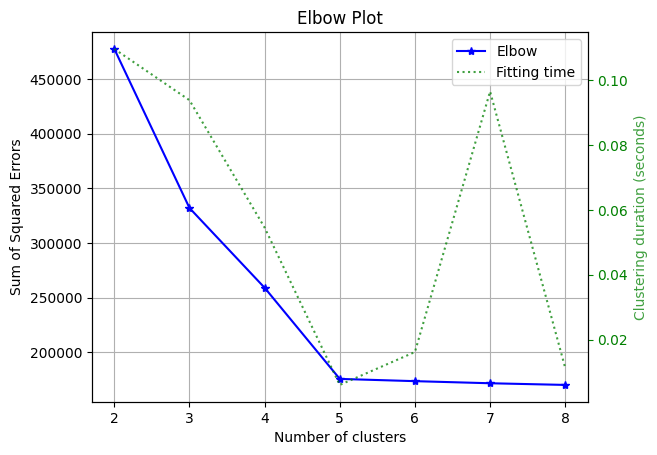

In [5]:
_ = plot.elbow_curve(X, model, range_n_clusters=(2, 3, 4, 5, 6, 7, 8))

In our curve, we see significant improvements when moving from 2 to 5 clusters; but increasing to 6 or larger does not yield substantial improvements; hence, we can conclude that 5 is the optimal number of clusters.

### `plot.silhouette_analysis`

We can visually represent the `silhouette_score` to assess the number of clusters. Remember that values close to +1 indicate that the clusters are well-separated. Another characteristic to consider is the size of each silhouette plot. If they're too different, it means some clusters are tiny while others are too large (see, for example the plots with `n_clusters` from 6 to 8: they all have some tiny clusters.

Note that the silhouette score reported on each plot (top-right corner) matches our previous table. Again, we see that the value is maximized when `n_clusters=5`, and that all clusters have similar size and silhouette scores, so we choose that as the optimal value.

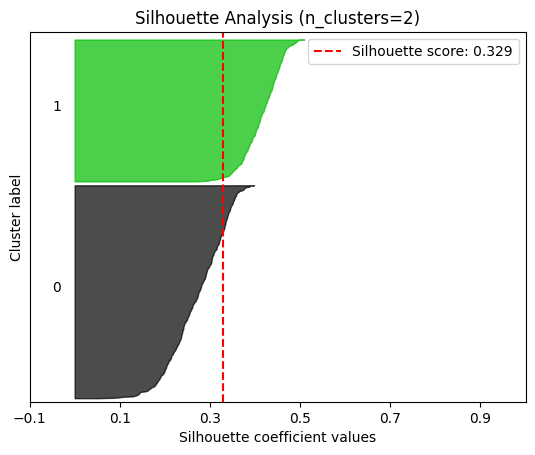

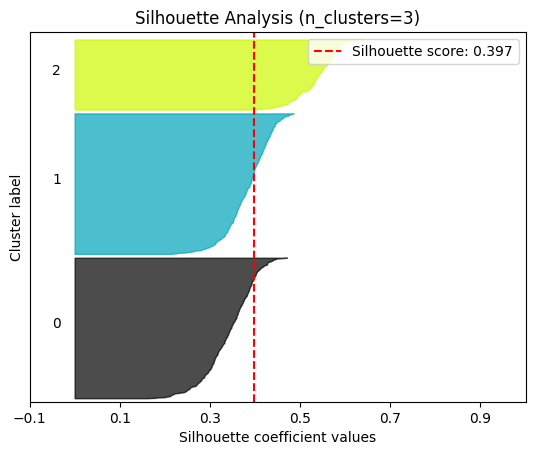

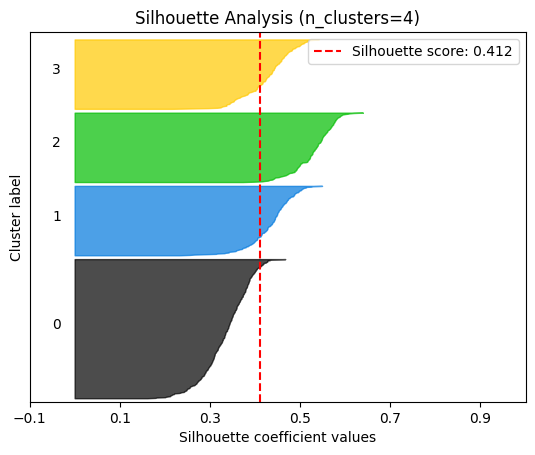

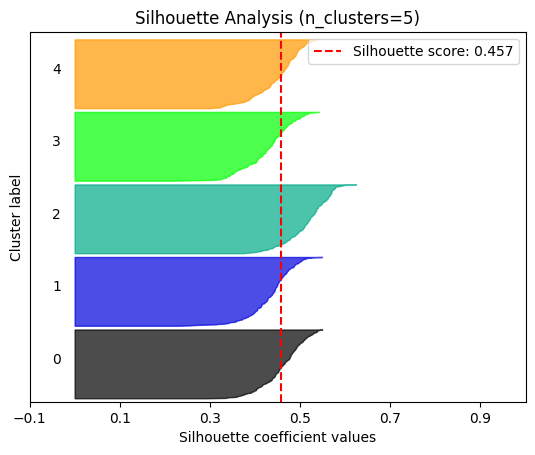

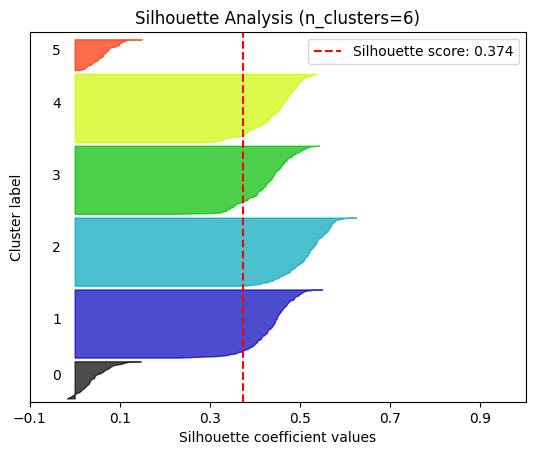

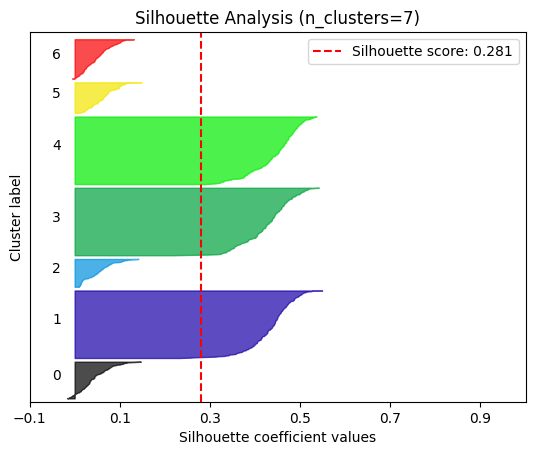

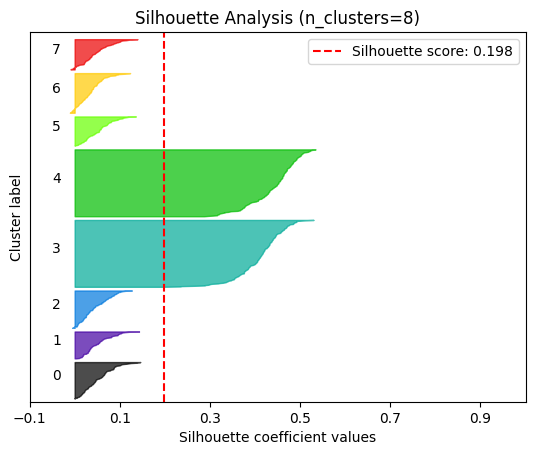

In [6]:
_ = plot.silhouette_analysis(X, model, range_n_clusters=(2, 3, 4, 5, 6, 7, 8))